# Thermodynamic controls on the geochemistry of ore-forming processes

Import...
- `reaktoro` (website, [documentation](https://reaktoro.org/api/), GitHub repo), a Python/C++ package for modelling chemically reactive systems, and 
- `thermofun` (website, Github repo), a Python package for calculating thermodynamic properties of substances at varied P-T-X conditions. 



In [1]:
import reaktoro as rkt
import thermofun as fun
import numpy as np
from matplotlib import pyplot as plt

Create a database object containing all of the thermodynamic and compositional data for each substance. 

In [2]:
database = fun.Database("../data/raw/thermodynamic_data/mines19-thermofun.json");
db = rkt.ThermoFunDatabase(database)
# db = rkt.SupcrtDatabase() 

How much reductant is required to consume metals? 

In [91]:
aqueous_phase = rkt.AqueousPhase(["H2O@", "H+", "OH-", 
                                "Na+", "NaOH@", "NaCl@", "HCl@", "Cl-", 
                                "H2S@", "HS-", "HSO4-", "SO4-2", 
                                "FeCl2@"
                                ])
mineral_phases = rkt.MineralPhases(["Pyrite", "Graphite"])

phases = rkt.Phases(db)

phases.add(aqueous_phase)
# phases.add(mineral_phases)

system = rkt.ChemicalSystem(phases)

In [92]:
T = 250 # [°C]
P = rkt.waterSaturationPressureWagnerPruss(T+273.15) # [bar]

- add Fe2O3 and NaCl until 1000 ppm Fe and 3 wt % NaCl

In [93]:
specs = rkt.EquilibriumSpecs(system)
specs.temperature()
specs.pressure()

In [94]:
def add_element_concentration_constraint(specs, element): 
    def get_element_concentration(props, element):
        element_concentration = 1e6 * props.elementMassInPhase(element, "AqueousPhase") / props.phaseProps("AqueousPhase").mass() # [ppm]

        return element_concentration

    idx_element_conc = specs.addInput(f"{element} concentration")  # add symbol for a new input condition to the equilibrium problem

    element_conc_constraint = rkt.ConstraintEquation()
    element_conc_constraint.id = f"{element} concentration"  # give some identification name to the constraint
    element_conc_constraint.fn = lambda props, w: get_element_concentration(props, element) - w[idx_element_conc]  # the residual function 

    specs.addConstraint(element_conc_constraint)

    return specs

In [96]:
add_element_concentration_constraint(specs, "Fe")
specs.openTo("FeCl2")

In [97]:
def add_salinity_constraint(specs): 

    def get_NaCl_concentration(props):
        NaCl_concentration = 100 * (props.elementMassInPhase("Na", "AqueousPhase") + props.elementMassInPhase("Cl", "AqueousPhase")) / props.phaseProps("AqueousPhase").mass() # [wt %]

        return NaCl_concentration

    idx_salinity = specs.addInput("salinity")  # add symbol for a new input condition to the equilibrium problem

    salinity_constraint = rkt.ConstraintEquation()
    salinity_constraint.id = "salinity"  # give some identification name to the constraint
    salinity_constraint.fn = lambda props, w: get_NaCl_concentration(props) - w[idx_salinity]  # the residual function 

    specs.addConstraint(salinity_constraint)

    return specs

In [98]:
add_salinity_constraint(specs)
specs.openTo("NaCl")

In [100]:
solver = rkt.EquilibriumSolver(specs)
conditions = rkt.EquilibriumConditions(specs)
conditions.temperature(25, "C")
conditions.pressure(1, "bar")
conditions.set("Fe concentration", 1000) # [ppm]
conditions.set("salinity", 3) # [wt %]

fluid = rkt.ChemicalState(system)
fluid.add("H2O@", 1, "kg")
# fluid.add("NaCl@", 10, "mol")

result = solver.solve(fluid, conditions)
outcome = result.optima.succeeded
print(f"converged: {outcome}")
fluid


converged: True


+---------------------+-------------+------+
| Property            |       Value | Unit |
+---------------------+-------------+------+
| Temperature         |    298.1500 |    K |
| Pressure            |      1.0000 |  bar |
| Charge:             | -4.5551e-16 |  mol |
| Element Amount:     |             |      |
| :: H                |  1.1102e+02 |  mol |
| :: O                |  5.5508e+01 |  mol |
| :: Na               |  5.0732e-01 |  mol |
| :: S                |  4.0000e-16 |  mol |
| :: Cl               |  5.4428e-01 |  mol |
| :: Fe               |  1.8480e-02 |  mol |
| Species Amount:     |             |      |
| :: H2O@             |  5.5508e+01 |  mol |
| :: H+               |  1.0539e-07 |  mol |
| :: OH-              |  9.4252e-08 |  mol |
| :: Na+              |  4.6948e-01 |  mol |
| :: NaOH@            |  2.0794e-08 |  mol |
| :: NaCl@            |  3.7844e-02 |  mol |
| :: HCl@             |  9.6579e-09 |  mol |
| :: Cl-              |  4.6948e-01 |  mol |
| :: H2S@ 

In [62]:
fluid.add("FeCl2@", 100, "mol")

In [63]:
get_element_concentration(rkt.ChemicalProps(fluid), "Fe")
        

autodiff.real(1.03564e-10, 0)

In [190]:
reductant = rkt.ChemicalState(system)
reductant.add("Graphite", 1, "mol")
reductant

+--------------------------+-------------+------+
| Property                 |       Value | Unit |
+--------------------------+-------------+------+
| Temperature              |    298.1500 |    K |
| Pressure                 |      1.0000 |  bar |
| Charge:                  | -4.0000e-16 |  mol |
| Element Amount:          |             |      |
| :: H                     |  1.0000e-15 |  mol |
| :: C                     |  1.0000e+00 |  mol |
| :: O                     |  1.1000e-15 |  mol |
| :: Na                    |  3.0000e-16 |  mol |
| :: S                     |  6.0000e-16 |  mol |
| :: Cl                    |  5.0000e-16 |  mol |
| :: Fe                    |  2.0000e-16 |  mol |
| Species Amount:          |             |      |
| :: H2O@                  |  1.0000e-16 |  mol |
| :: H+                    |  1.0000e-16 |  mol |
| :: OH-                   |  1.0000e-16 |  mol |
| :: Na+                   |  1.0000e-16 |  mol |
| :: NaOH@                 |  1.0000e-16 |  mol |


In [53]:
metals = ["Co", "Cu", "Ag", "Zn", "Pb", "Fe", "Ni", "Au"]
other_elements = ["H", "O", "Na", "Cl", "S"]
system_elements = metals + other_elements

In [83]:
def get_minerals_w_elements(db, elements, exclusive=True): 
    minerals = []
    for species in db.species(): 
        if species.aggregateState().name == "CrystallineSolid": 
            species_elements = species.elements().symbols()
            if exclusive==True: 
                if all(element in elements for element in species_elements): 
                    minerals.append(species.name())
            else: 
                if any(element in elements for element in species_elements): 
                    minerals.append(species.name())


    return minerals

In [84]:
systems = {}
for metal in metals: 
    elements = [metal] + other_elements

    # add minerals
    minerals = get_minerals_w_elements(db, elements)

    if minerals:
        mineral_phases = rkt.MineralPhases(minerals)

        # add aqueous phase
        aqueous_phase = rkt.AqueousPhase(rkt.speciate(list(set(other_elements + mineral_phases.elements()))))
        print(minerals)

['Disodium monoxid', 'Halite', 'Thenardite']
['Chalcocite', 'Chalcocyanite', 'Covellite', 'Cu', 'Cuprite', 'Disodium monoxid', 'Halite', 'Tenorite', 'Thenardite']
['Acanthite', 'Ag', 'Chlorargyrite', 'Disodium monoxid', 'Halite', 'Thenardite']
['Disodium monoxid', 'Halite', 'Sphalerite', 'Thenardite', 'Wurtzite', 'Zincite', 'Zinkosite']
['Anglesite', 'Cotunnite', 'Disodium monoxid', 'Galena', 'Halite', 'Litharge', 'Minium', 'Plattnerite', 'Thenardite']
['Disodium monoxid', 'Fe(OH)3', 'Ferric sulfate', 'Ferrous oxide', 'Goethite', 'Halite', 'Hematite', 'Lawrencite', 'Magnetite', 'Marcasite', 'Molysite', 'Pyrite', 'Pyrrhotite', 'Thenardite', 'Troilite', 'Wustite']
['Disodium monoxid', 'Halite', 'Thenardite']
['Au', 'Disodium monoxid', 'Halite', 'Thenardite']


In [24]:
mineral_phases = ["Acanthite", "Ag", "Chlorargyrite", "Bornite", "Chalcocite", "Chalcocyanite", "Chalcopyrite", "Covellite", "Cu", "Cuprite", "Tenorite", "Sphalerite", "Wurtzite"]
aqueous_phase = rkt.AqueousPhase(rkt.speciate("H O Na Cl Co S"))
mineral_phases = rkt.MineralPhases(["Linnaeite", "Cattierite", "Co-pentlandite", "CoO(s)", "Co3O4(s)", "Co(s)"])

phases = rkt.Phases(db)

phases.add(aqueous_phase)
phases.add(mineral_phases)

system = rkt.ChemicalSystem(phases)

NameError: name 'Chlorargyrite' is not defined

In [25]:
for species in db.species(): 
    if "Zn" in species.elements().symbols() and species.aggregateState().name == "CrystallineSolid": 
        print(species.name())

Franklinite
Smithsonite
Sphalerite
Wurtzite
Zinc titanium sp
Zincite
Zinkosite


Let's create a reaction that describes the solubility of galena ($PbS$) in an aqueous fluid: 
$$
PbS_{(s)} + 2Cl^-_{(aq)} + 2O_{2(g)} \leftrightarrow PbCl_{2(aq)} + SO^{-2}_{4(aq)}
$$

In [10]:
rxn = db.reaction("Galena + 2*Cl- + 2*O2@ = PbCl2@ + SO4-2")

Next, we'll calculate and plot the log of the equillibrium constant, $K$, for a range of temperatures at saturated water vapor pressure. 
Recall that the equilibrium constant is defined as follows: 
$$
K = \prod_i a_i
$$ 
where $i$ indicates the ith substance in the reaction, and $a$ is that substance's activity (i.e., its "thermodynamic concentration"). 

In [33]:
temperature = np.linspace(100, 300) + 273.15 #[K]
pressure = len(temperature)*[500*1e5] # [Pa]

# pressure = [rkt.waterSaturationPressureWagnerPruss(T) for T in temperature] #[Pa]

In [34]:
logK = []
for T,P in zip(temperature, pressure): 
    logK.append(rxn.props(T, P).lgK[0])

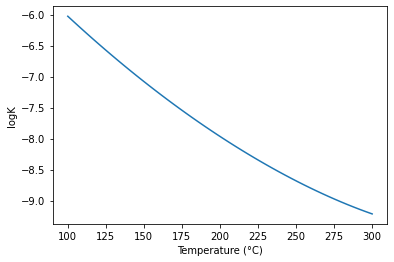

In [35]:
plt.plot(temperature-273.15, logK)
plt.xlabel("Temperature (°C)")
plt.ylabel("logK");

We can now plot the reaction in $log(f_{O_2})-pH$ space, where these two parameters are master control variables in many geochemical environments. To do this, we first take the $log_{10}$ of the equilibrium constant expression: 
$$
logK = log(a_{PbCl_{2(aq)}}) + log(a_{SO^{-2}_{4(aq)}}) - 2log(a_{O_{2(g)}}) - 2log(a_{Cl^-_{(aq)}}) - log(a_{PbS_{(s)}})
$$
If we assume that $PbS_{(s)}$ is pure (i.e., the activity of the $PbS$ component in the phase galena is 1), the last term becomes 0 and the expression simplifies to: 
$$
logK = log(a_{PbCl_{2(aq)}}) + log(a_{SO^{-2}_{4(aq)}}) - 2log(a_{O_{2(g)}}) - 2log(a_{Cl^-_{(aq)}})
$$

Rearranging this, we get: 
$$
log(a_{O_{2(g)}}) = log(a_{Cl^-_{(aq)}}) - 0.5log(a_{PbCl_{2(aq)}}) - 0.5log(a_{SO^{-2}_{4(aq)}}) - logK

% logK = log(a_{PbCl_{2(aq)}}) + log(a_{SO^{-2}_{4(aq)}}) - 2log(a_{O_{2(g)}}) - 2log(a_{Cl^-_{(aq)}}) - log(a_{PbS_{(s)}})
$$

Using the calculated equilibrium constant, and by specifying activities for $Cl^-_{(aq)}$ and $PbCl_{2(aq)}$, we can plot this equation in $log(f_{O_2})-pH$ space. 

In [ ]:
aCl = 1

Let's create a reaction that describes the solubility of galena ($PbS$) in an aqueous fluid: 
$$
PbS_{(s)} + 2Cl^-_{(aq)} + 2O_{2(g)} \leftrightarrow PbCl_{2(aq)} + SO^{-2}_{4(aq)}
$$

In [8]:
rxn = db.reaction("Galena + 2*Cl- + 2*O2(g) = PbCl2@ + SO4-2")

In [9]:
rxn = db.reaction("Galena + 2*H+ = Pb+2 + H2S@")
logK_2 = []

pressure = len(temperature)*[500*1e5]
for T,P in zip(temperature, pressure): 
    logK_2.append(rxn.props(T, P).lgK[0])


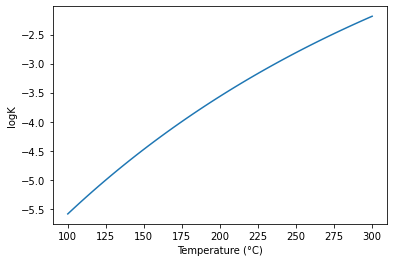

In [10]:
plt.plot(temperature-273.15, logK_2)
plt.xlabel("Temperature (°C)")
plt.ylabel("logK");

In [11]:
rxn = db.reaction("Galena + 2*H+ + 2*Cl- = PbCl2@ + H2S@")
logK_2 = []

pressure = len(temperature)*[500*1e5]
for T,P in zip(temperature, pressure): 
    logK_2.append(rxn.props(T, P).lgK[0])

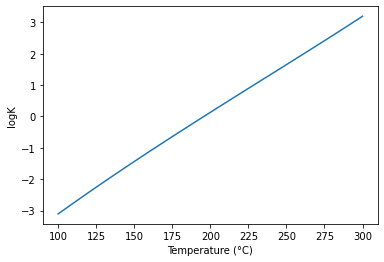

In [12]:
plt.plot(temperature-273.15, logK_2)
plt.xlabel("Temperature (°C)")
plt.ylabel("logK");